In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import json
from equistore import Labels, TensorBlock, TensorMap
from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.acdc_mini import * #acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import *
import matplotlib.pyplot as plt
from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
import copy
from utils.model_hamiltonian import *
from ase.units import Hartree

## Manipulate Hamiltonian into blocks

In [3]:
frames = ase.io.read("data/hamiltonian/ethanol-hamiltonian/ethanol_4500.xyz",":400")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [4]:
#jorbs = json.load(open('data/water-hamiltonian/water_orbs.json', "r"))
jorbs = json.load(open('data/hamiltonian/ethanol-hamiltonian/orbs_saph_ethanol.json', "r"))
orbs = {}
zdic = {"O" : 8, "C":6, "H":1}
for k in jorbs:
    orbs[zdic[k]] = jorbs[k]

In [5]:
hams = np.load("data/hamiltonian/ethanol-hamiltonian/ethanol_saph_orthogonal.npy", allow_pickle=True)[:len(frames)]
eigvals = np.linalg.eigvalsh(hams)
# NO NEED TO CORRECT L1 ORDER FOR SAPH ORTHOGONALIZED MATRICES...
#for i, f in enumerate(frames):
#    hams[i] = fix_pyscf_l1(hams[i], f, orbs)

blocks = dense_to_blocks(hams, frames, orbs)

In [6]:
cg = ClebschGordanReal(3)

In [7]:
coupled = couple_blocks(blocks, cg)

fock_bc = coupled

## Feature computation

In [8]:
rascal_hypers = {
    "interaction_cutoff": 5.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 4,
    "max_angular": 3,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)

In [9]:
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

In [10]:
rho1i = acdc_standardize_keys(rhoi)
rho1i.keys_to_properties(['species_neighbor'])
gij =  acdc_standardize_keys(gij)

In [11]:
%%time
rho2i = cg_increment(rho1i, rho1i, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 2.64 s, sys: 194 ms, total: 2.84 s
Wall time: 2.84 s


In [12]:
%%time
rho2i_comp, _ = compress_features(rho2i, threshold=1e-12)

CPU times: user 17.6 s, sys: 184 ms, total: 17.8 s
Wall time: 4.49 s


In [13]:
%%time
rho3i = cg_increment(rho2i_comp, rho1i, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 6.68 s, sys: 340 ms, total: 7.02 s
Wall time: 6.51 s


In [14]:
%%time
rho3i_comp, _ = compress_features(rho3i, threshold=1e-14)

CPU times: user 9.19 s, sys: 419 ms, total: 9.61 s
Wall time: 2.41 s


In [15]:
%%time
rho4i = cg_increment(rho3i_comp, rho1i, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 1.42 s, sys: 16.1 ms, total: 1.44 s
Wall time: 934 ms


In [16]:
rho4i_comp, _ = compress_features(rho4i, threshold=1e-16)

In [17]:
%%time
rho1ij = cg_increment(rho1i, gij, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 10.1 s, sys: 355 ms, total: 10.4 s
Wall time: 10.3 s


In [18]:
%%time
rho2ij = cg_increment(rho2i_comp, gij, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 22.2 s, sys: 996 ms, total: 23.2 s
Wall time: 23.2 s


In [19]:
%%time
rho3ij = cg_increment(rho3i_comp, gij, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

CPU times: user 5.62 s, sys: 0 ns, total: 5.62 s
Wall time: 5.62 s


In [20]:
ham_feats = hamiltonian_features(rho4i, rho3ij)

In [61]:
#In rho4i_comp, some blocks are being dropped
#TODO: include an exception in the fit function to account fo that

## fitting and prediction

In [57]:
FR = Fock_regression(alpha=1e-16)

In [58]:
tf = [10,50,80,160,240,320]
mae_full = []
mae_eva = []
for i in tf:
    aa = FR.fit(ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(i), dtype=np.int32).reshape(-1,1)) ),
       fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(i), dtype=np.int32).reshape(-1,1)) ))
    pred_dense, pred_eigvals = FR.predict(ham_feats, frames, orbs)
    
    mae_full.append(np.abs(np.mean(hams - pred_dense))*Hartree)
    eigval_loss = []
    for a in range(len(frames)):
        eigval_loss.append(eigvals[a] - pred_eigvals[a])

    mae_eva.append(np.abs(np.mean(eigval_loss))*Hartree)

Text(0, 0.5, 'MAE/eV')

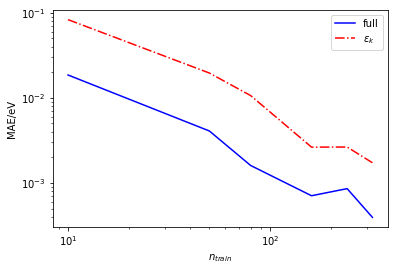

In [59]:
plt.loglog(tf, mae_full, 'b', label='full')
plt.loglog(tf, mae_eva, 'r-.', label='$\epsilon_{k}$')
plt.legend(loc ="upper right");
plt.xlabel('$n_{train}$')
plt.ylabel('MAE/eV')